## League of legends win predictions

This notebook uses the [Kaggle dataset League of Legends Ranked Matches]( https://www.kaggle.com/paololol/league-of-legends-ranked-matches) which contains 180,000 ranked games of League of Legends starting from 2014. Using this data we build an XGBoost model to predict if a player’s team will win based on statistics about how that player played the match.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

In [2]:
# read in the data
prefix = "C:/Users/amfua/Documents/Python_projects/Project_1/"
matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

#X = allstats.drop(["win"], axis=1)
#y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    allstats[feature_name] /= allstats["duration"] / 60 # per minute rate

# convert to fraction of game
allstats["longesttimespentliving"] /= allstats["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in allstats.columns]
allstats.columns = feature_names

In [3]:
allstats.head(2)

,id_x,matchid,player,championid,ss1,ss2,role,position,id_y,gameid,...,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,champlvl,Pink wards bought per min.,Wards bought per min.,Wards placed per min.,wardskilled,firstblood
0,9,10,1,19,4,11,3,1,10,3187427022,...,0.03143,0.03143,0.0,6.631744,14,0.03143,0.0,0.534311,0.09429,0
1,10,10,2,267,3,4,2,0,10,3187427022,...,0.03143,0.03143,0.0,6.631744,14,0.03143,0.0,0.534311,0.09429,0


In [4]:
allstats[['win']].head(4)

,win
0,0
1,0
2,0
3,0


In [5]:
allstats.shape

(1537132, 72)

In [6]:
reduce_df = allstats.sample(100000, random_state=10)

In [7]:
### Train Pycaret

In [8]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(reduce_df, target = 'win', session_id = 123, train_size = 0.8, fold=3)
# normalize = True, normalize_method = 'robust'

,Description,Value
0,Session id,123
1,Target,win
2,Target type,Binary
3,Original data shape,"(100000, 72)"
4,Transformed data shape,"(100000, 72)"
5,Transformed train set shape,"(80000, 72)"
6,Transformed test set shape,"(20000, 72)"
7,Numeric features,71
8,Preprocess,True
9,Imputation type,simple


In [9]:
# OOP API
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9008,0.9669,0.9047,0.8979,0.9013,0.8017,0.8017,1.9033
rf,Random Forest Classifier,0.8924,0.9621,0.9015,0.8854,0.8934,0.7847,0.7848,10.0567
et,Extra Trees Classifier,0.8857,0.9596,0.8894,0.8830,0.8862,0.7715,0.7715,5.0867
lightgbm,Light Gradient Boosting Machine,0.8845,0.9582,0.8955,0.8763,0.8858,0.7690,0.7692,1.6967
ridge,Ridge Classifier,0.8677,0.9387,0.8367,0.8920,0.8635,0.7354,0.7368,0.3500
lda,Linear Discriminant Analysis,0.8674,0.9385,0.8362,0.8919,0.8632,0.7348,0.7363,0.6600
gbc,Gradient Boosting Classifier,0.8571,0.9380,0.8612,0.8543,0.8577,0.7142,0.7142,39.6433
ada,Ada Boost Classifier,0.8408,0.9230,0.8286,0.8494,0.8388,0.6815,0.6818,8.6133
dt,Decision Tree Classifier,0.8320,0.8320,0.8333,0.8312,0.8322,0.6639,0.6639,2.2167
qda,Quadratic Discriminant Analysis,0.6492,0.6711,0.5602,0.7413,0.5868,0.2984,0.3418,0.6600


In [10]:
# display best model
display(best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

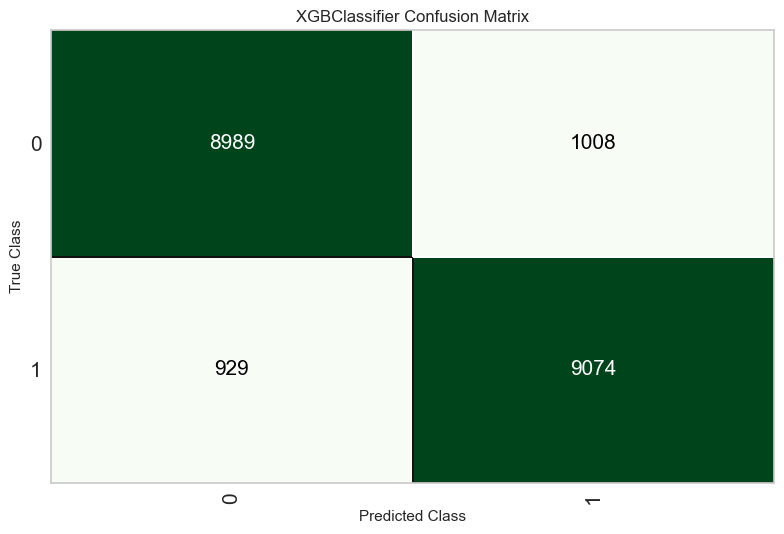

In [11]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

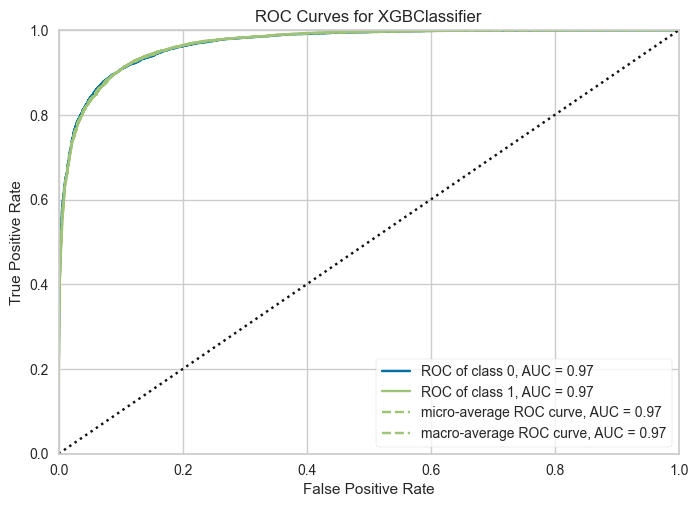

In [12]:
# plot AUC
plot_model(best, plot = 'auc')

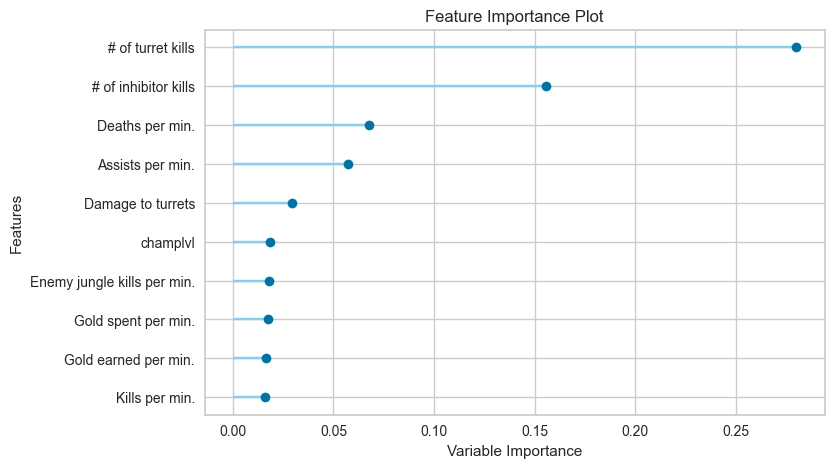

In [13]:
# plot feature importance
plot_model(best, plot = 'feature')